In [3]:
import os
import numpy as np
import cv2
import random
from sklearn.preprocessing import LabelBinarizer

# ---------------- PARAMETERS ----------------
img_width, img_height = 128, 64
captcha_length = 5  # adjust to your dataset
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'  # all chars

# Initialize LabelBinarizer
lb = LabelBinarizer()
lb.fit(list(characters))  # preserve order of characters
classes = lb.classes_  # use this for decoding later

# ---------------- FUNCTIONS ----------------
def encode_label(text, lb=lb, max_length=captcha_length):
    """
    Convert captcha text (before underscore) to one-hot encoding.
    Case-sensitive.
    """
    text = text.split('_')[0]  # take only part before '_'
    length = min(len(text), max_length)
    encoded = np.zeros((max_length, len(lb.classes_)), dtype=np.float32)
    for i in range(length):
        encoded[i] = lb.transform([text[i]])
    return encoded

def load_data(directory):
    images = []
    labels = []
    all_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    for file in all_files:
        # Read and normalize image
        img_path = os.path.join(directory, file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_width, img_height))
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=-1)
        images.append(image)
        
        # Encode label
        label_text = os.path.splitext(file)[0]
        labels.append(encode_label(label_text))
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='float32')
    
    # Shuffle
    c = list(zip(images, labels))
    random.shuffle(c)
    images, labels = zip(*c)
    
    return np.array(images), np.array(labels)

# ---------------- LOAD DATA ----------------
train_dir = "downloads/college/sem5/ML_mini/captcha_solver/dataset/train"
test_dir  = "downloads/college/sem5/ML_mini/captcha_solver/dataset/test"

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Label classes:", classes)

Train shape: (1505, 64, 128, 1) (1505, 5, 62)
Test shape: (381, 64, 128, 1) (381, 5, 62)
Label classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

num_chars = captcha_length
num_classes = len(classes)

def build_cnn_model():
    model = Sequential()

    # Conv layers
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    # Flatten + Dense
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_chars*num_classes, activation='softmax'))
    model.add(Reshape((num_chars, num_classes)))  # reshape to (num_chars, num_classes)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 310)                 │         317,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 5, 62)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,188,662 (65.57 MB)

 Trainable params: 17,188,662 (65.57 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.0553 - loss: 3.6038 - val_accuracy: 0.1134 - val_loss: 2.8658
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.1173 - loss: 3.2276 - val_accuracy: 0.4509 - val_loss: 1.9849
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - accuracy: 0.3002 - loss: 2.6022 - val_accuracy: 0.7690 - val_loss: 0.9524
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.4330 - loss: 2.1441 - val_accuracy: 0.8924 - val_loss: 0.5258
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.5159 - loss: 1.8521 - val_accuracy: 0.9454 - val_loss: 0.2722
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.5737 - loss: 1.6679 - val_accuracy: 0.9617 - val_loss: 0.1935
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.6217 - loss: 1.4691 - val_accuracy: 0.9748 - val_loss: 0.1252
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.7055 - loss: 1.0984 - val_accu

In [35]:
cnn_model.save(r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_cnn_model_v2.h5")
print("Model saved as captcha_cnn_model_v2.h5")

Model saved as captcha_cnn_model_v2.h5


CNN model loaded successfully
Total images: 381
Correct predictions: 363
Accuracy: 95.28%
Results saved to cnn_test_results_case_sensitive.csv


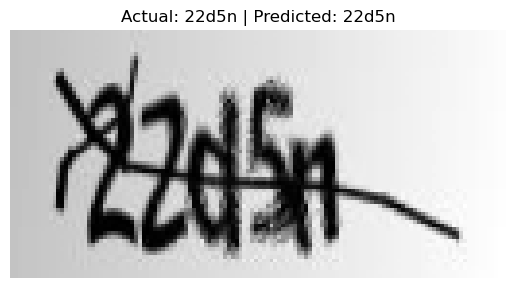

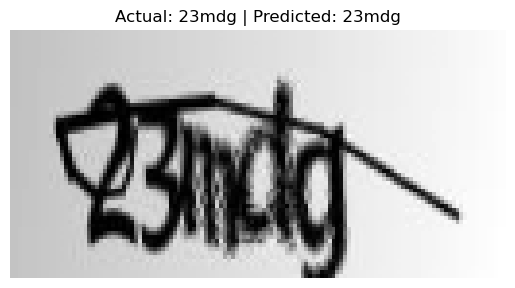

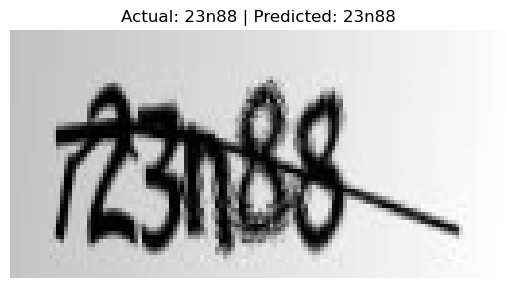

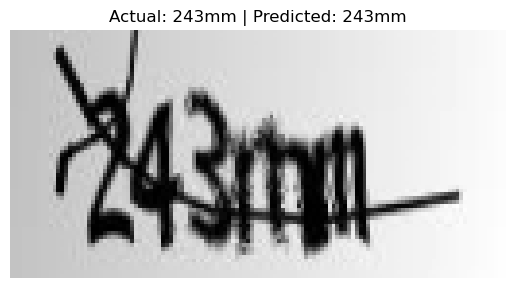

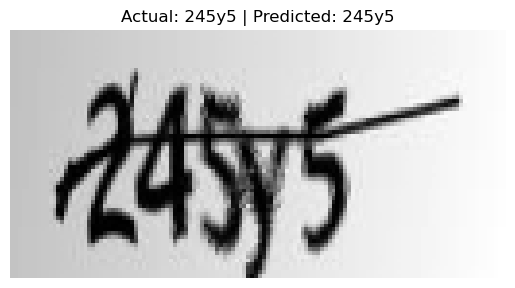

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
import csv

# ---------------- PARAMETERS ----------------
img_width, img_height = 128, 64
captcha_length = 5
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# ---------------- LABEL BINARIZER ----------------
lb = LabelBinarizer()
lb.fit(list(characters))
classes = lb.classes_

# ---------------- LOAD CNN MODEL ----------------
cnn_model_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_cnn_model_v2.h5"
cnn_model = load_model(cnn_model_path)
print("CNN model loaded successfully")

# ---------------- IMAGE PREPROCESSING ----------------
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # (H,W,1)
    img = np.expand_dims(img, axis=0)   # (1,H,W,1)
    return img

# ---------------- CNN DECODER ----------------
def decode_cnn_prediction(pred, classes=classes):
    """Greedy decoding for CNN (num_chars, num_classes)"""
    text = ""
    for i in range(pred.shape[0]):
        char_index = np.argmax(pred[i])
        text += classes[char_index]
    return text

# ---------------- TEST MULTIPLE SAMPLES ----------------
test_dir = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\dataset\test"
all_files = [f for f in os.listdir(test_dir) if f.endswith('.png')]

results = []
correct_count = 0

for file in all_files:
    img_path = os.path.join(test_dir, file)
    true_text = os.path.splitext(file)[0]
    
    # Predict
    img = preprocess_image(img_path)
    pred = cnn_model.predict(img, verbose=0)
    pred_text = decode_cnn_prediction(pred[0])
    
    results.append((file, true_text, pred_text))
    if true_text == pred_text:
        correct_count += 1

# ---------------- ACCURACY ----------------
total = len(all_files)
accuracy = (correct_count / total) * 100
print(f"Total images: {total}")
print(f"Correct predictions: {correct_count}")
print(f"Accuracy: {accuracy:.2f}%")

# ---------------- SAVE RESULTS ----------------
csv_path = "cnn_test_results_case_sensitive.csv"
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Filename", "Actual", "Predicted"])
    writer.writerows(results)
print(f"Results saved to {csv_path}")

# ---------------- DISPLAY FIRST 5 SAMPLES ----------------
for i in range(min(5, total)):
    file, actual, predicted = results[i]
    img_path = os.path.join(test_dir, file)
    img = preprocess_image(img_path)
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.title(f"Actual: {actual} | Predicted: {predicted}")
    plt.axis('off')
    plt.show()

In [1]:
import os
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, LSTM, Lambda
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer

# ------------------------ PARAMETERS ------------------------
img_width, img_height = 128, 64       # fixed size
captcha_length = 5                     # number of characters per captcha
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
num_classes = len(characters) + 1     # +1 for CTC blank

In [3]:
# Label encoder
lb = LabelBinarizer()
lb.fit(list(characters))

def encode_label(text, lb=lb, max_length=captcha_length):
    text = text.split('_')[0]  # remove extra suffix if any
    length = min(len(text), max_length)
    encoded = np.zeros((max_length, len(lb.classes_)))
    for i in range(length):
        encoded[i] = lb.transform([text[i]])
    return encoded

def load_data(directory):
    images, labels = [], []
    files = [f for f in os.listdir(directory) if f.endswith('.png')]
    for file in files:
        # load image
        img_path = os.path.join(directory, file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_width, img_height))
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=-1)
        images.append(image)

        # encode label
        label_text = os.path.splitext(file)[0]
        labels.append(encode_label(label_text))

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='float32')

    # shuffle
    c = list(zip(images, labels))
    random.shuffle(c)
    images, labels = zip(*c)
    return np.array(images), np.array(labels)

# Load datasets
train_dir = "downloads/college/sem5/ML_mini/captcha_solver/dataset/train"
test_dir  = "downloads/college/sem5/ML_mini/captcha_solver/dataset/test"

X_train, y_train = load_data(train_dir)
X_test, y_test   = load_data(test_dir)

# Convert one-hot to integer for CTC
y_train_int = np.argmax(y_train, axis=-1)
y_test_int  = np.argmax(y_test, axis=-1)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1505, 64, 128, 1) (1505, 5, 62)
Test shape: (381, 64, 128, 1) (381, 5, 62)


In [7]:
inputs = Input(shape=(img_height, img_width, 1), name='input_image')

# CNN
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

# Determine time steps dynamically
shape = tf.keras.backend.int_shape(x)  # (batch, h, w, c)
time_steps = shape[2]                  # width after pooling
features_per_step = shape[1] * shape[3]  # height * channels

# LSTM
x = Reshape((time_steps, features_per_step))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Dense output
x = Dense(num_classes, activation='softmax')(x)

# CTC Inputs
labels = Input(name='labels', shape=(captcha_length,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

# CTC Loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [x, labels, input_length, label_length])

# Compile training model
ctc_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})

In [9]:
train_input_len = np.ones((X_train.shape[0], 1)) * time_steps
train_label_len = np.ones((X_train.shape[0], 1)) * captcha_length

test_input_len = np.ones((X_test.shape[0], 1)) * time_steps
test_label_len = np.ones((X_test.shape[0], 1)) * captcha_length

train_inputs = {
    'input_image': X_train,
    'labels': y_train_int,
    'input_length': train_input_len,
    'label_length': train_label_len
}
test_inputs = {
    'input_image': X_test,
    'labels': y_test_int,
    'input_length': test_input_len,
    'label_length': test_label_len
}

train_outputs = np.zeros((X_train.shape[0], 1))
test_outputs  = np.zeros((X_test.shape[0], 1))


In [11]:
history = ctc_model.fit(
    train_inputs,
    train_outputs,
    validation_data=(test_inputs, test_outputs),
    batch_size=32,
    epochs=50  # adjust for convergence
)

Epoch 1/50

48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - loss: 22.0891 - val_loss: 17.5049
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - loss: 19.9440 - val_loss: 17.5109
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - loss: 19.9365 - val_loss: 17.6277
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step - loss: 19.9175 - val_loss: 17.6227
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - loss: 19.6882 - val_loss: 16.7693
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - loss: 18.4926 - val_loss: 16.2983
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - loss: 18.2392 - val_loss: 16.0766
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - loss: 18.1061 - val_loss: 15.9411
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - loss: 17.9315 - val_loss: 15.6265
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step - loss: 17.7102 - val_loss: 15.2137
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - loss: 17.3101 - val_loss: 14.9870
Epoch 12/50
48/48 

In [13]:
# ------------------------ SAVE MODELS ------------------------

# Save full training model (with CTC Lambda)
ctc_model.save(r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_ctc_train_model_v2.h5")
print("Training model saved as captcha_ctc_train_model_v2.h5")

# Build and save inference model (CNN+BiLSTM -> softmax)
inference_model = Model(inputs=inputs, outputs=x)
inference_model.save(r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_infer_model_v2.h5")
print("Inference model saved as captcha_infer_model_v2.h5")

# Save metadata
import json
meta_data = {
    "characters": characters,
    "captcha_length": captcha_length,
    "img_width": img_width,
    "img_height": img_height
}
with open(r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_meta_v2.json", "w") as f:
    json.dump(meta_data, f)
print("Metadata saved as captcha_meta_v2.json")

Training model saved as captcha_ctc_train_model_v2.h5
Inference model saved as captcha_infer_model_v2.h5
Metadata saved as captcha_meta_v2.json


Inference model loaded successfully
Metadata loaded: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ 5 128 64
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted CAPTCHA text: 2NBCX


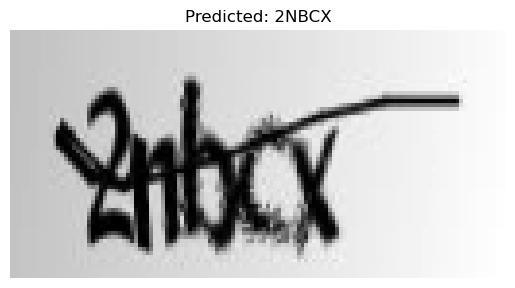

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import load_model

# ------------------------ LOAD NEW MODELS ------------------------
train_model_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_ctc_train_model_v2.h5"
infer_model_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_infer_model_v2.h5"
meta_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_meta_v2.json"

# Load inference model
inference_model = load_model(infer_model_path, compile=False)
print("Inference model loaded successfully")

# Load metadata
with open(meta_path, "r") as f:
    meta = json.load(f)
characters = meta["characters"]
captcha_length = meta["captcha_length"]
img_width = meta["img_width"]
img_height = meta["img_height"]
print("Metadata loaded:", characters, captcha_length, img_width, img_height)

# ------------------------ FUNCTIONS ------------------------
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)      # (64,128,1)
    img = np.expand_dims(img, axis=0)       # (1,64,128,1)
    return img

def decode_captcha(pred, characters=characters):
    out_best = np.argmax(pred, axis=-1)
    out_str = []
    blank_idx = len(characters)
    prev_char = -1
    for c in out_best:
        if c != prev_char and c != blank_idx:
            out_str.append(characters[c])
        prev_char = c
    return ''.join(out_str)

def predict_captcha(image_path):
    img = preprocess_image(image_path)
    pred = inference_model.predict(img)
    text = decode_captcha(pred[0])
    print("Predicted CAPTCHA text:", text)
    # display
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.title(f"Predicted: {text}")
    plt.axis('off')
    plt.show()

# ------------------------ TEST ------------------------
# Use the same test image that was giving wrong prediction before
test_image_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\dataset\test\2nbcx.png"
predict_captcha(test_image_path)

Inference model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted CAPTCHA text: 2nbcx


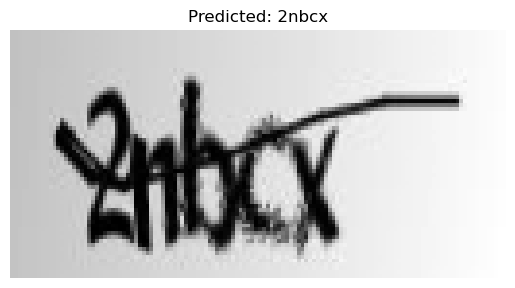

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer

# ---------------- PARAMETERS ----------------
img_width, img_height = 128, 64
captcha_length = 5
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Initialize LabelBinarizer exactly like during training
lb = LabelBinarizer()
lb.fit(list(characters))
classes = lb.classes_

# ---------------- LOAD INFERENCE MODEL & METADATA ----------------
infer_model_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_infer_model_v2.h5"
inference_model = load_model(infer_model_path, compile=False)
print("Inference model loaded successfully")

# ---------------- IMAGE PREPROCESSING ----------------
def preprocess_image(img_path):
    """
    Grayscale, resize, normalize, add batch & channel dims
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # (H,W,1)
    img = np.expand_dims(img, axis=0)   # (1,H,W,1)
    return img

# ---------------- CTC DECODER USING LabelBinarizer ----------------
def decode_captcha(pred, lb=lb):
    """
    Greedy CTC decoding using LabelBinarizer classes
    """
    out_best = np.argmax(pred, axis=-1)
    out_str = []
    blank_idx = len(lb.classes_)
    prev_char = -1
    for c in out_best:
        if c != prev_char and c != blank_idx:
            out_str.append(lb.classes_[c])
        prev_char = c
    return ''.join(out_str)

# ---------------- PREDICT SINGLE CAPTCHA ----------------
def predict_captcha(image_path):
    img = preprocess_image(image_path)
    pred = inference_model.predict(img)
    text = decode_captcha(pred[0])
    
    print("Predicted CAPTCHA text:", text)
    
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.title(f"Predicted: {text}")
    plt.axis('off')
    plt.show()

# ---------------- TEST EXAMPLE ----------------
test_image_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\dataset\test\2nbcx.png"
predict_captcha(test_image_path)

Total images: 381
Correct predictions: 3
Accuracy: 0.79%
Results saved to captcha_test_results.csv


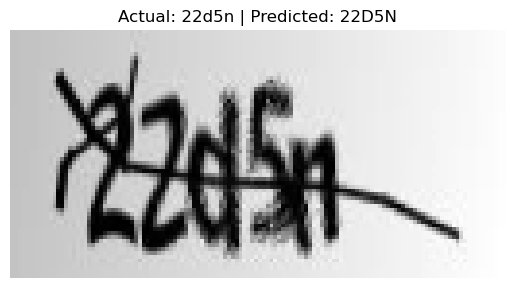

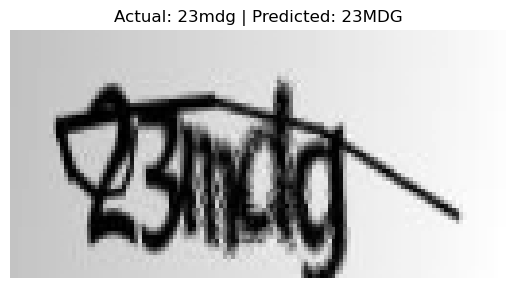

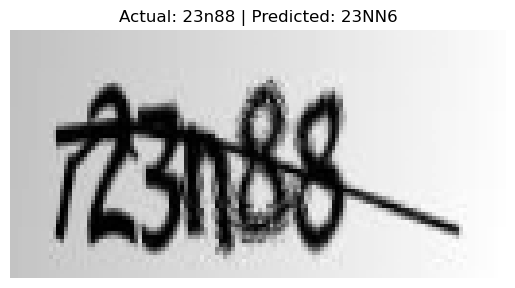

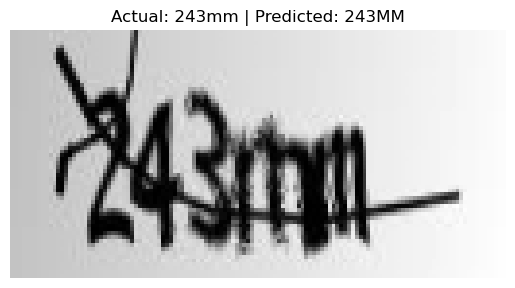

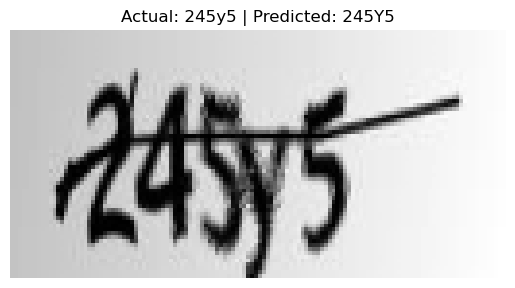

In [23]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------ SETTINGS ------------------------
test_dir = r"downloads/college/sem5/ML_mini/captcha_solver/dataset/test"
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# ------------------------ FUNCTIONS ------------------------
def preprocess_image(img_path, img_width=128, img_height=64):
    """Preprocess image same as training"""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)  # shape (1, H, W, 1)
    return img

def decode_captcha(pred, characters=characters):
    """Greedy CTC decoding"""
    out_best = np.argmax(pred, axis=-1)
    out_str = []
    blank_idx = len(characters)
    prev_char = -1
    for c in out_best:
        if c != prev_char and c != blank_idx:
            out_str.append(characters[c])
        prev_char = c
    return ''.join(out_str)

# ------------------------ EVALUATE TEST SET ------------------------
test_images = [f for f in os.listdir(test_dir) if f.endswith('.png')]
results = []
correct_count = 0

for img_file in test_images:
    img_path = os.path.join(test_dir, img_file)
    img = preprocess_image(img_path)
    
    pred = inference_model.predict(img, verbose=0)  # <-- suppress progress output
    text_pred = decode_captcha(pred[0])
    
    actual_text = os.path.splitext(img_file)[0].split('_')[0]
    is_correct = (actual_text == text_pred)
    if is_correct:
        correct_count += 1
    
    results.append({
        'filename': img_file,
        'actual': actual_text,
        'predicted': text_pred,
        'correct': is_correct
    })

# ------------------------ METRICS ------------------------
total_images = len(test_images)
accuracy = correct_count / total_images * 100
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_count}")
print(f"Accuracy: {accuracy:.2f}%")

# ------------------------ SAVE RESULTS ------------------------
df_results = pd.DataFrame(results)
df_results.to_csv('captcha_test_results.csv', index=False)
print("Results saved to captcha_test_results.csv")

# ------------------------ OPTIONAL: Display some samples ------------------------
for i in range(min(5, total_images)):
    row = results[i]
    img_path = os.path.join(test_dir, row['filename'])
    img = preprocess_image(img_path)
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.title(f"Actual: {row['actual']} | Predicted: {row['predicted']}")
    plt.axis('off')
    plt.show()

Inference model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113

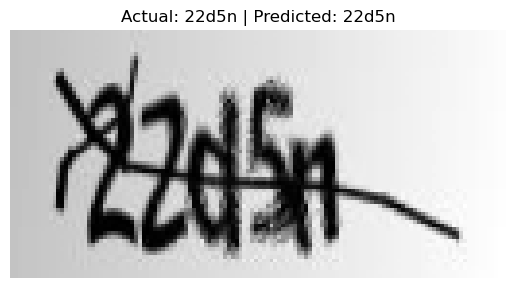

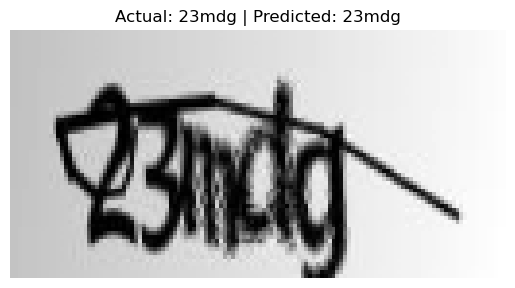

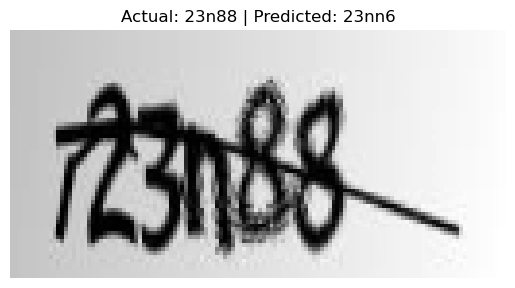

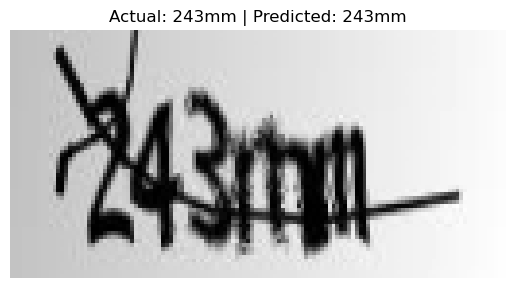

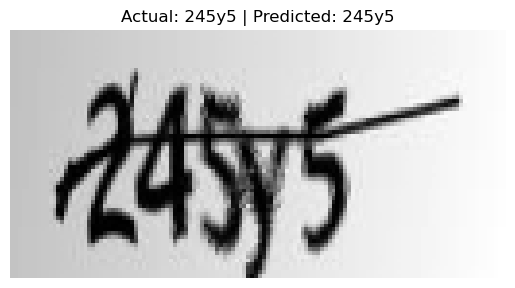

In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
import csv

# ---------------- PARAMETERS ----------------
img_width, img_height = 128, 64
captcha_length = 5
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Initialize LabelBinarizer exactly like during training
lb = LabelBinarizer()
lb.fit(list(characters))
classes = lb.classes_

# ---------------- LOAD INFERENCE MODEL ----------------
infer_model_path = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_infer_model_v2.h5"
inference_model = load_model(infer_model_path, compile=False)
print("Inference model loaded successfully")

# ---------------- IMAGE PREPROCESSING ----------------
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # (H,W,1)
    img = np.expand_dims(img, axis=0)   # (1,H,W,1)
    return img

# ---------------- CTC DECODER USING LabelBinarizer ----------------
def decode_captcha(pred, lb=lb):
    out_best = np.argmax(pred, axis=-1)
    out_str = []
    blank_idx = len(lb.classes_)
    prev_char = -1
    for c in out_best:
        if c != prev_char and c != blank_idx:
            out_str.append(lb.classes_[c])
        prev_char = c
    return ''.join(out_str)

# ---------------- TEST MULTIPLE SAMPLES ----------------
test_dir = r"C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\dataset\test"
all_files = [f for f in os.listdir(test_dir) if f.endswith('.png')]

results = []
correct_count = 0

for file in all_files:
    img_path = os.path.join(test_dir, file)
    true_text = os.path.splitext(file)[0]  # filename = label
    pred_text = decode_captcha(inference_model.predict(preprocess_image(img_path))[0])
    results.append((file, true_text, pred_text))
    if true_text == pred_text:
        correct_count += 1

# ---------------- ACCURACY ----------------
total = len(all_files)
accuracy = (correct_count / total) * 100
print(f"Total images: {total}")
print(f"Correct predictions: {correct_count}")
print(f"Accuracy: {accuracy:.2f}%")

# ---------------- SAVE RESULTS ----------------
csv_path = "captcha_test_results_case_sensitive.csv"
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Filename", "Actual", "Predicted"])
    writer.writerows(results)
print(f"Results saved to {csv_path}")

# ---------------- DISPLAY FIRST 5 SAMPLES ----------------
for i in range(min(5, total)):
    file, actual, predicted = results[i]
    img_path = os.path.join(test_dir, file)
    img = preprocess_image(img_path)
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.title(f"Actual: {actual} | Predicted: {predicted}")
    plt.axis('off')
    plt.show()